<a href="https://colab.research.google.com/github/alex-jk/painting-lora-finetune/blob/main/neural_style_transfer_photos_to_paintings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Neural style transfer — brief**
**Goal**<br>
Turn your photo into a painting-like image **without moving objects**: keep the photo’s layout, borrow the painting’s colors/texture.

**How it works (high level)**<br>
We create an output image `X` and **optimize its pixels** so that:<br>
• its **deep features** (from a CNN) match the photo → preserves structure/content;<br>
• its **feature statistics** (Gram matrices) match the painting → transfers style/brushwork.

**VGG-19**<br>
**VGG-19** is a classic **convolutional neural network (CNN)** trained on ImageNet. It stacks many conv layers that detect edges, textures, parts, and objects.<br>
• **Shallow layers** respond to color/texture; **deep layers** to object/layout.<br>
• We **freeze** VGG (no training) and use it only to extract features that act as our “perceptual rulers.”<br>
• Matching **deep** VGG features → keeps object placements. Matching **Gram stats** across layers → injects painting style.

<h3><font color="#0b3d91">How the neural style transfer model is trained (fast/feed-forward version)</font></h3>

**Notation**
- `f_phi`: trainable **stylizer** CNN (the only network you update)
- `VGG`: frozen **loss network** (used only to compute losses)
- `C`: content image, `S`: style image
- `X = f_phi(C)`: stylized output

**Training loop**
1. **Freeze VGG.** Use it only to extract features for the losses (no weight updates).
2. **Choose a style** image `S` (or sample from a style set).
3. **For each content image `C`:**
    - **Forward pass:** compute `X = f_phi(C)` (run `C` through the stylizer to get the current stylized guess).
    - **Extract features (with frozen VGG):** get feature maps `F_l(C)`, `F_l(X)`, and `F_l(S)` from selected layers `l`.
    - **Content loss:** make `F_l(X)` close to `F_l(C)` on deeper layers (preserves layout/structure).
    - **Style loss:** make **Gram matrices** of `X` match those of `S` across chosen layers (captures texture/brushwork).
    - **TV loss (optional):** add a small total-variation penalty on `X` to encourage smoothness.
    - **Total loss:** `L = lambda_c * L_content + lambda_s * L_style + lambda_tv * L_tv`.
    - **Backprop:** send gradients through VGG into `f_phi` (VGG stays frozen) and **update only `phi`** (e.g., Adam).
4. **Repeat** over batches until validation loss plateaus. The trained `f_phi` then stylizes any new `C` in a single forward pass.

> **Alternative (optimization-based NST):** don’t learn `f_phi`. Initialize `X` (e.g., `X <- C`) and **optimize the pixels of `X`** directly to minimize the same losses with VGG frozen.


**Pipeline**<br>
Load & normalize images → run through frozen VGG → compute **content loss** (deep layer), **style loss** (Gram matrices across several layers), plus tiny **total variation (TV)** smoothing → backprop gradients **to the image pixels** with L-BFGS/Adam until it looks right.

**Total Variation (TV) smoothing** - A regularizer that penalizes rapid pixel-to-pixel changes. It prefers images that are locally smooth (piecewise-smooth) without simply blurring everything.

<h3><font color="#0b3d91">Gram matrices (style loss)</font></h3>

**Setup (for one VGG layer `l`)**
- Feature maps: `F_l(X)` has shape `[C, H, W]` (C channels, H×W spatial).
- Flatten spatial dims: `F = reshape(F_l(X), [C, H*W])`.
- **Gram matrix (per layer):**
  - Start with features `F_l(X)` of shape `[C, H, W]`.
  - Flatten spatial dims → `F` has shape `[C, N]`, where `N = H * W`.
  - Indices: `i, j ∈ {1..C}` are **channel indices**; `p ∈ {1..N}` is the **pixel (spatial) index** after flattening.
  - Define the `[C, C]` matrix `G` by  
    `G[i, j] = (1/N) * sum_{p=1..N} F[i, p] * F[j, p]`.
  - This is the **average product across all spatial positions** of channels `i` and `j`.  
    Averaging over `p` removes location and keeps **co-activation (texture) statistics**.

**Intuition**
- Entry `G[i, j]` is the dot product between channel `i` and `j` across all pixels → how strongly they **co-activate**.
- Averaging over locations discards exact positions, so Gram matrices capture **texture/brushwork statistics** (which features occur together), not layout.
- Matching `G_l(X)` to `G_l(S)` makes `X` use the same color/texture patterns as the style image at that layer’s scale.

**Why multiple layers?**
- Shallow layers → fine textures/colors; deeper layers → broader patterns.
- Summing style losses over several layers gives a **multi-scale** style match.

**Style loss formula**
- Per layer: `L_style_l = || G_l(X) - G_l(S) ||_F^2`
- Total style loss: weighted sum over chosen layers.
- Normalize by `H*W` (or `C*H*W`) to keep values scale-stable.

**Install dependencies**

In [1]:
# Colab usually has recent torch/torchvision, but this is safe.
!pip -q install --upgrade torch torchvision pillow
import torch, torchvision, PIL
print("Torch:", torch.__version__, "| Vision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch: 2.8.0+cu126 | Vision: 0.23.0+cu126
CUDA available: True


In [2]:
import math
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image

#### **Set device and ImageNet normalization (for VGG-19 features)**

- **Device selection:** Use GPU (`cuda`) if available; otherwise fall back to CPU. All tensors/ops must be on the **same device**.
- **ImageNet normalization:** VGG-19 expects RGB inputs scaled to **[0,1]** and normalized per channel with:
  - mean = `[0.485, 0.456, 0.406]`
  - std  = `[0.229, 0.224, 0.225]`
<br>We apply it as: `(x - mean) / std` (broadcast per channel over H×W).
- **Why:** Feeding the exact normalization used in training keeps VGG feature distributions correct; skipping it can cause unstable optimization or odd colors.
- **`.to(device)` on mean/std:** Puts these constants on the same device as your images to avoid device-mismatch errors.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).to(device)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).to(device)

###**NST Code**

#### Image I/O helpers

**`load_image(path, target_long_side=None)`**
- **Force RGB (3 channels):** keeps shape consistent for VGG / PyTorch.
- **Optional shrink (keep aspect ratio):** if `target_long_side` is set, scale the image so its **longer side = target_long_side**.  
  *Why:* fewer pixels ⇒ faster, uses less memory. (Halving width & height ≈ **4× fewer pixels**.)
- **High-quality resize (`Image.LANCZOS`):** when you shrink, many pixels are merged. A good filter **averages smartly** so diagonals don’t look like **stair-steps (“jaggies”)** and fine textures don’t turn into **wavy stripes**. Cleaner inputs ⇒ cleaner VGG features.
- **To tensor in `[0,1]`:** `transforms.ToTensor()` gives a float tensor **(3, H, W)** scaled to `[0,1]`.
- **Add batch dim:** `unsqueeze(0)` → **(1, 3, H, W)** because models expect a batch.
- **Send to device:** `.to(device)` moves it to CPU or GPU.

**`save_image(tensor, path)`**
- **Stop tracking gradients:** `detach()` — we’re just saving numbers now.
- **Keep valid range:** `clamp(0,1)` so colors aren’t out of bounds.
- **Back to CPU & drop batch:** `cpu().squeeze(0)` → **(3, H, W)**.
- **Write file:** `transforms.ToPILImage()(x).save(Path(path))`.

In [4]:
def load_image(path, target_long_side=None):
    img = Image.open(path).convert("RGB")
    if target_long_side is not None:
        w, h = img.size
        scale = target_long_side / max(w, h)
        img = img.resize((round(w*scale), round(h*scale)), Image.LANCZOS)
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)  # (1,3,H,W) in [0,1]
    return x

def save_image(tensor, path):
    x = tensor.detach().clamp(0,1).cpu().squeeze(0)
    transforms.ToPILImage()(x).save(Path(path))

#### Normalization module

**What it does**
- Takes an image batch `x` with shape **(N, 3, H, W)** in **[0,1]** and applies **per-channel** ImageNet normalization:  
  `x_norm = (x − mean) / std`.
- Stores `mean` and `std` as tensors shaped **(1, 3, 1, 1)** so they **broadcast** across batch and spatial dims (H×W).

**Why we need it**
- **VGG-19** was trained on ImageNet-normalized RGB. Feeding inputs in the same scale makes VGG features **comparable and stable** for style/content losses.
- Using `register_buffer(...)` puts `mean/std` on the **right device**, includes them in the **state_dict**, and keeps them **non-trainable** (not updated by the optimizer).

*Typical constants:* `mean = [0.485, 0.456, 0.406]`, `std = [0.229, 0.224, 0.225]`.

In [5]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.register_buffer("mean", mean.view(1,3,1,1))
        self.register_buffer("std",  std.view(1,3,1,1))
    def forward(self, x): return (x - self.mean) / self.std

### VGG “taps” — which layers we read and why

**What is a tap?**  
A *tap* is a layer in VGG where we **read** the activation (feature map) during the forward pass. VGG is **frozen** (not trained). We only use the tapped layers in our losses; **all other layers are ignored**.

**Are we using all layers?**  
**No.** We select a small subset:
- **Content taps** → preserve the photo’s layout/structure.
- **Style taps** → capture texture/brush/color statistics at multiple scales.

**Our choices**
```python
# human-readable names for vgg19.features indices
VGG_LAYER_NAMES = {1:"relu1_1", 6:"relu2_1", 11:"relu3_1", 20:"relu4_1", 22:"relu4_2", 29:"relu5_1"}

# use this deep layer to keep object/layout structure
CONTENT_LAYERS = ["relu4_2"]

# use these (shallow→deep) to capture style across scales
STYLE_LAYERS   = ["relu1_1","relu2_1","relu3_1","relu4_1","relu5_1"]

In [6]:
# VGG layer taps
VGG_LAYER_NAMES = {1:"relu1_1", 6:"relu2_1", 11:"relu3_1", 20:"relu4_1", 22:"relu4_2", 29:"relu5_1"}
CONTENT_LAYERS = ["relu4_2"]
STYLE_LAYERS   = ["relu1_1","relu2_1","relu3_1","relu4_1","relu5_1"]

### `VGGFeatures` — frozen VGG wrapper that returns only the layers we care about

**Goal:** In one forward pass, (1) normalize the input exactly like ImageNet and (2) collect activations at selected “tap” layers for our losses.

**How it’s built (`__init__`):**
- Load `vgg19.features` (try the new weights API; fall back to `pretrained=True`).
- Call `eval()` and set `requires_grad_(False)` → VGG is **frozen** (we never train it).
- Create `Normalization(mean, std)` so inputs are ImageNet-normalized before entering VGG.

**What `forward(x)` does:**
1. Normalize: `x ← (x − mean) / std`.
2. Run through VGG **layer by layer**.
3. If the current layer index is listed in `VGG_LAYER_NAMES`, **store that activation** under its readable name (e.g., `"relu4_2"`).
4. Return a dict mapping names → activations (each `(N, C, H, W)`), e.g.:
   `{"relu1_1": T1, "relu2_1": T2, "relu3_1": T3, "relu4_1": T4, "relu4_2": T5, "relu5_1": T6}`.

**Why this design:**
- We do **not** use all VGG layers. We tap a small subset:
  - **Content loss:** compare `X` vs `C` at a deep tap (e.g., `"relu4_2"`).
  - **Style loss:** compare Gram stats at several shallow→deep taps.
- Freezing VGG + correct normalization → features are **stable and comparable**; only your stylizer (or pixels) is updated.

In [7]:
class VGGFeatures(nn.Module):
    def __init__(self):
        super().__init__()
        # Compatibility with different torchvision versions
        try:
            feats = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_FEATURES).features
        except Exception:
            feats = models.vgg19(pretrained=True).features
        self.vgg = feats.eval().to(device)
        for p in self.vgg.parameters(): p.requires_grad_(False)
        self.norm = Normalization(IMAGENET_MEAN, IMAGENET_STD)
    def forward(self, x):
        out = {}
        x = self.norm(x)
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            if i in VGG_LAYER_NAMES:
                out[VGG_LAYER_NAMES[i]] = x
        return out

### Precompute content & style targets — what this code does

1. **Load images** (`C`, `S`) at a manageable size → tensors `(1,3,H,W)` on the correct device.
2. **Frozen VGG taps**: build `VGGFeatures()` (it normalizes to ImageNet and returns only the tapped layers).
3. **Forward once**: run `C` and `S` through VGG → get dictionaries of tapped activations: `c_feats`, `s_feats`.
4. **Content target(s)**: take the content image activations at `CONTENT_LAYERS` (e.g., `relu4_2`). These preserve layout/structure.
5. **Style targets**: for each layer in `STYLE_LAYERS`, compute a **Gram matrix** from the style activations:
   - reshape features to `(C, N)` where `C`=channels and `N=H*W`;
   - build a `(C×C)` matrix of **average channel-wise products** → captures texture/color statistics while ignoring exact positions.
   - **Why Gram matrices at multiple style layers?**  
Style is about which features co-occur, not where. A Gram matrix captures channel co-activation (second-order stats) and ignores spatial layout, so matching `G_l(X)` to `G_l(S)` transfers texture/brushwork without copying positions. Using several layers (shallow→deep) covers multi-scale style; normalizing by `H×W` keeps losses comparable across sizes.

6. **Sanity check**: print shapes of targets to confirm they were created.

**Use next:** feed `content_targets` and `style_targets` into your loss:
- (a) **Optimize pixels** `X` directly, or
- (b) **Train a stylizer network** `f_ϕ` so that `X = f_ϕ(C)`.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

CONTENT = "/content/drive/MyDrive/nst/images/content.jpg"
STYLE   = "/content/drive/MyDrive/nst/images/style.jpg"

Mounted at /content/drive


In [9]:
# Step: precompute content/style targets with VGG taps
# 1) Load images at a manageable size
# 1) Load images at a manageable size
target_long_side = 512
C = load_image(CONTENT, target_long_side=target_long_side)  # was "path/to/content.jpg"
S = load_image(STYLE,   target_long_side=target_long_side)  # was "path/to/style.jpg"

# 2) Frozen VGG feature extractor with your taps & normalization
vgg = VGGFeatures()

# 3) Forward once to get tapped activations
with torch.no_grad():
    c_feats = vgg(C)   # dict: {layer_name: activation}
    s_feats = vgg(S)

# 4) Build targets
content_targets = {name: c_feats[name].detach() for name in CONTENT_LAYERS}

def gram(feat):
    # feat: (1, C, H, W) -> (C, C) average pairwise channel products
    _, C, H, W = feat.shape
    F = feat.view(C, H * W)         # (C, N)
    return (F @ F.t()) / (H * W)    # (C, C)

style_targets = {name: gram(s_feats[name]).detach() for name in STYLE_LAYERS}

# 5) Sanity check
print("Content taps:")
for k, v in content_targets.items():
    print(f"  {k}: {tuple(v.shape)}")
print("Style Gram targets:")
for k, G in style_targets.items():
    print(f"  {k}: {tuple(G.shape)}")

# content_targets and style_targets are now ready for the next step (optimize pixels X or train a stylizer f_phi).

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:05<00:00, 102MB/s]


Content taps:
  relu4_2: (1, 512, 64, 48)
Style Gram targets:
  relu1_1: (64, 64)
  relu2_1: (128, 128)
  relu3_1: (256, 256)
  relu4_1: (512, 512)
  relu5_1: (512, 512)


In [10]:
# Optimize X (stylized image) using your precomputed targets, then save it.

steps, lr = 300, 0.02
w_content, w_style, w_tv = 1.0, 10.0, 1e-5

def total_variation(x):
    tv_h = (x[:, :, 1:, :] - x[:, :, :-1, :]).abs().mean()
    tv_w = (x[:, :, :, 1:] - x[:, :, :, :-1]).abs().mean()
    return tv_h + tv_w

X = C.clone().requires_grad_(True)
opt = torch.optim.Adam([X], lr=lr)

for t in range(1, steps + 1):
    opt.zero_grad()
    feats = vgg(X)

    # content loss (keep layout/structure)
    Lc = sum(torch.nn.functional.mse_loss(feats[n], content_targets[n]) for n in CONTENT_LAYERS)

    # style loss (match Gram stats)
    Ls = 0.0
    for n in STYLE_LAYERS:
        Ls += torch.nn.functional.mse_loss(gram(feats[n]), style_targets[n])

    # smoothness
    Ltv = total_variation(X)

    loss = w_content*Lc + w_style*Ls + w_tv*Ltv
    loss.backward()
    opt.step()

    with torch.no_grad():
        X.clamp_(0, 1)

    if t % 50 == 0 or t == steps:
        print(f"[{t}/{steps}] Lc={Lc.item():.4f}  Ls={Ls.item():.4f}  Ltv={Ltv.item():.6f}  Total={loss.item():.4f}")

save_image(X, "/content/out.png")
print("Saved: /content/out.png")

[50/300] Lc=4.5650  Ls=0.4851  Ltv=0.161912  Total=9.4164
[100/300] Lc=3.9050  Ls=0.3183  Ltv=0.153401  Total=7.0884
[150/300] Lc=3.6980  Ls=0.2722  Ltv=0.150105  Total=6.4203
[200/300] Lc=3.7141  Ls=0.2922  Ltv=0.151246  Total=6.6359
[250/300] Lc=3.4561  Ls=0.2322  Ltv=0.148784  Total=5.7779
[300/300] Lc=3.4081  Ls=0.2310  Ltv=0.148486  Total=5.7184
Saved: /content/out.png


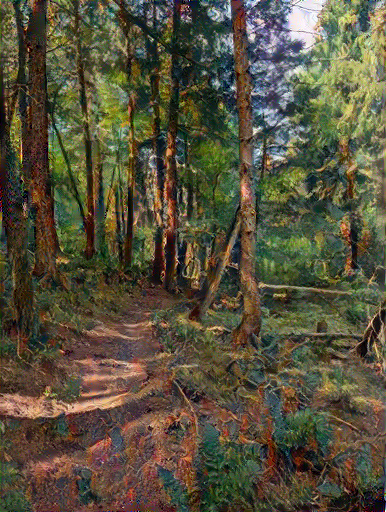

In [11]:
from PIL import Image
display(Image.open("/content/out.png"))

**Next Step:** Re-run style transfer so the output looks **more like the painting** and **less like a photo**.

1) **Set stronger style settings**
   - `w_content = 0.3` → care *less* about matching the photo’s structure.
   - `w_style = 25.0` → care *more* about matching the painting’s textures/colors.
   - `w_tv = 5e-5` → a bit more smoothing to reduce tiny photo details/noise.

2) **Tell the code which style layers matter most**
   - `style_layer_weights`: higher weights for **shallow layers** (`relu1_1`, `relu2_1`) amplify fine brush/texture; deeper layers get less weight so large-scale photo structure doesn’t dominate.

3) **Start from noise (not the photo)**
   - `X = torch.rand_like(C)` → no photo details “leak through,” so the result is freer to follow the painting’s look.

4) **Optimization loop (500 steps)**
   - Run `X` through frozen VGG to get features.
   - **Content loss (`Lc`)**: compare deep features of `X` vs content image `C` (keeps rough layout, but with low weight now).
   - **Style loss (`Ls`)**: at each style layer, compare Gram matrices of `X` vs style `S`, scaled by `style_layer_weights` (drives texture/brushwork).
   - **Total variation (`Ltv`)**: small smoothness term (reduces speckle).
   - Combine: `loss = w_content*Lc + w_style*Ls + w_tv*Ltv`, backprop, update **pixels of `X`** with Adam, then clamp to `[0,1]`.

5) **Result**
   - Saves the stronger, more painterly image to: **`/content/out_stronger.png`**.
